<a href="https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/modified_base_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Modified Base Tutorial</h1>

The modified base tutorial is intended as a simple guide for handling the modified-base information output by the Guppy basecaller. We will walk through the data provided in the `.fast5` file output by Guppy and demonstrate a method to store the data in `.bam` format to make it easier to handle with common standard bioinformatic tools.

The tutorial is provided with a sample dataset for chromosome 20 of the GIAB NA12878 sample, and the workflow can be used to address such questions as:

* How can CpG related 5mC base-modifications be extracted from a FAST5 file?
* Where is the genome do these base-modifications occur?
* How prevalent are base-modifications at given genomic locations?

Methods used in this tutorial include:

- Python for statistical analysis and reporting, including  use of [`pandas`](https://pandas.pydata.org/), [`numpy`](https://numpy.org/), and [`bokeh`](https://docs.bokeh.org/en/latest/index.html), 
- Programs from [`medaka`](https://github.com/nanoporetech/medaka/) for processing `.fast5` and `.bam` files with modified base data.

Computational requirements for this tutorial include:

- Computer running the **EPI2ME Labs** notebook Server
- At least 8 Gb RAM

⚠️ **Warning:** This notebook has been saved with its outputs for demostration purposed. It is recommeded to select `Edit > Clear all outputs` before using the notebook to analyse your own data.



## Data preparation

To start analysing our experiment we must first collate our data. The workflow below expects to be given a single data folder. It will search this folder to find `.fast5` files containing modified base data from the Guppy basecaller.

Before anything else we will create and set a working directory:

In [1]:
# create a work directory and move into it
tutorial_name = 'modbase_tutorial'
working_dir = '/epi2melabs/{}'.format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

/epi2melabs/modbase_tutorial


### Sample Data

To use this tutorial with sample data we can download the files using the `linux` command `wget`. To execute the command click on the cell and then press Command/Ctrl-Enter, or click the Play symbol to the left-hand side.

To get started we will download a sample sequencing dataset. The data is available in two forms:

*   `.fast5` files: files output by the Guppy basecaller (~180Gb).
*   `.bam` file: a processed version of the Guppy `.fast5` files with reads aligned to a reference sequences and modified-base data stored within an industry standard [format](https://samtools.github.io/hts-specs/SAMv1.pdf). (~8Gb).

The `.bam` download has the advantage of being much smaller. In the tutorial we will show how it is created from the `.fast5` files, this step can naturally be skipped if the `.bam` is used. The `.fast5` files are not used in this tutorial after the conversion step.


In [0]:
#@markdown **Select download type and press Play**
downloads = "bam only" #@param ["bam only", "fast5 only", "fast5 + bam"]

## download the data
location='https://ont-research.s3-eu-west-1.amazonaws.com/labs_resources/modbase_tutorial/'
if "fast5" in downloads:
    !echo 'Downloading `.fast5` data...'
    !wget "$location"/sample_modbase.tar
    !echo 'Extracting `.fast5` data...'
    !tar -xvf sample_modbase.tar
if "bam" in downloads:
    !echo 'Downloading `.bam` data...'
    !wget "$location"onll04465.bam
    !wget "$location"onll04465.bam.bai


To view the outcome of the download we can use the `tree` command to show the contents of the working directory:

In [0]:
!tree .

.
├── onll04465.bam
└── onll04465.bam.bai

0 directories, 2 files


The files should also appear in the File Browser to the left-hand side of the screen.

For our analysis we will also need the human genome reference (*note that this download is quite large (~5Gb), it includes both the reference sequence and indexes required for analysis*):

In [0]:
!wget https://ont-research.s3-eu-west-1.amazonaws.com/labs_resources/grch38.tar.gz
!tar -xzvf grch38.tar.gz

The reference contained within the above download is that which can also be obtained [here](http://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/001/405/GCA_000001405.15_GRCh38/seqs_for_alignment_pipelines.ucsc_ids/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz), the reasons for using this file are presented in Heng Li's [blog post](https://lh3.github.io/2017/11/13/which-human-reference-genome-to-use).

The sample data is a set of `.fast5` files from a PromethION sequencing experiment. They have been prefiltered to reads derived from human chromosome 20. This was achieved by using [`minimap2`](https://github.com/lh3/minimap2) to align reads to the human reference genome, filtering the results to include only chromosome 20 alignments, extracting the read identifiers, and finally using the `filter_reads` program from [`fast5_research`](https://github.com/nanoporetech/fast5_research)

### Using your own data

If you wish to analyse your own data rather than the sample data, you can edit the value of the `data_folder` variable below. To find the correct full path of a directory you can navigate to it in
the `Files` browser to the left-hand side, right-click on the file and select `Copy path`:

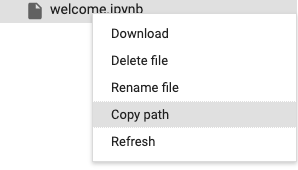

When pasting the path in the code cell you will have to remove the preceding `/` character.


### Data entry

Having downloaded the sample data, or locating your own data in the file browser, we need to provide the filepaths as input to the notebook. This is done in the form below, after updating the values, be sure to press the play button.



> **If you want simply to plot all the graphs in this tutorial for your dataset, rather than working through the tutorial, select `Run after` from the `Runtime` menu above after executing the cell below.**

In [4]:
#@markdown Enter the paths to you input files and output folder here:

# set variables for our inputs
data_folder='sample_modbase'  #@param {type: "string"}
output_folder='analysis'  #@param {type: "string"}
reference_genome='grch38/grch38.fasta.gz' #@param {type: "string"}

# run a command to concatenate all the files together
!echo "Making output folder"
!test -f "$reference_genome" || "WARNING: Reference file does not exist"
!mkdir -p "$output_folder"

Making output folder


## Modified base base-calling

The Guppy basecaller software includes a model for the detection of base modifications. The version of Guppy at the time of writing (3.3.3) supports modifications that include 5mC in a [CpG context](https://en.wikipedia.org/wiki/CpG_site), [Dcm](https://en.wikipedia.org/wiki/DNA_methylation#In_bacteria) (5mC motifs CCAGG and CCTGG) and [Dam](https://en.wikipedia.org/wiki/Dam_methylase), 6mA GATC motif.

The base-calling software outputs a `.fastq` file that includes the canonical sequence base and augments the `.fast5` file with a table of probabilities that represent that a given base has been modified. The figure below shows the contents of a `.fast5` file visualised with the [`hdfview`](https://www.hdfgroup.org/downloads/hdfview/) software. The figure that shows for a single selected read the fastq and base-modification probabilities and their hierarchical structure.

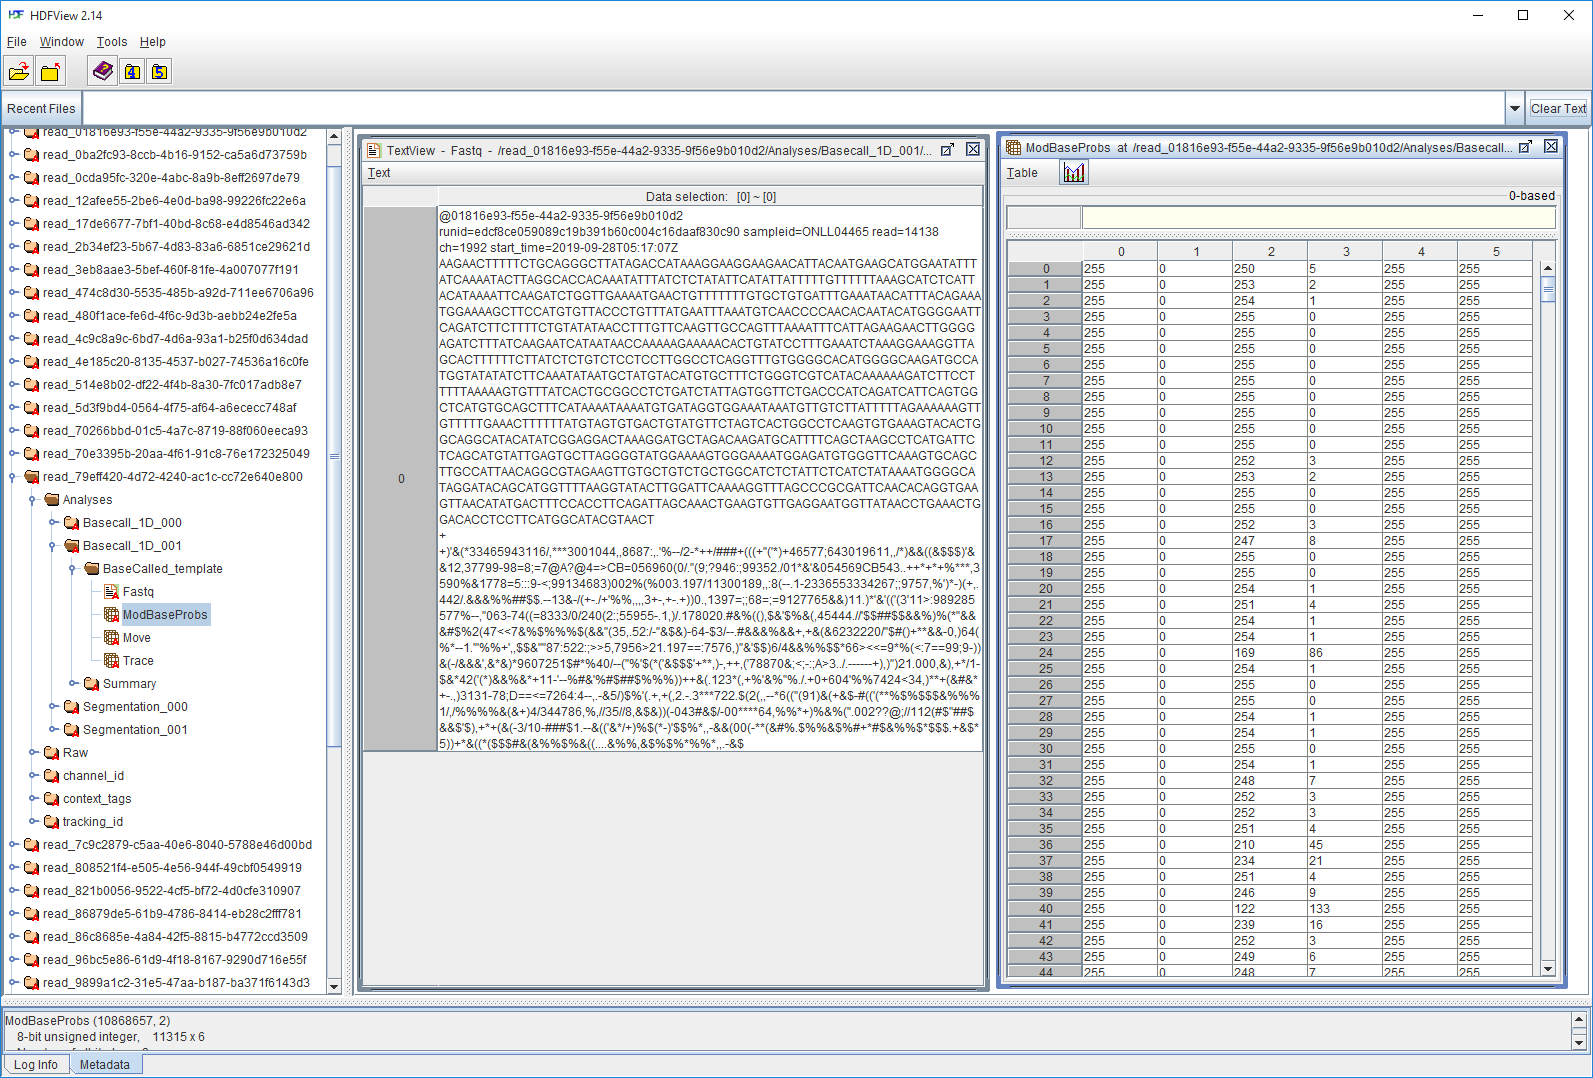

The probability table to the right-hand side deserves some explanation.

The table is a two-dimensional array, where each row of the table corresponds to a base in the basecalled sequence; there are as many rows in the table as there are bases in the basecall.

The columns of the table correspond to different base identities. The ordering of the columns is defined by the precise basecaller model used, but is commonly:

    A, 6mA, C, 5mC, G, T

(The [`ont-fast5-api`](https://github.com/nanoporetech/ont_fast5_api) can be used to determine this order for a given file).

Entries in the table score the relative probability that a position in the basecall should be determined to be a modified (or canonical) base. The scoring is expressed in a an integral range 0-255; the scores for a set of mutual bases (e.g. `A` and `6mA`, or `C` and `5mC`) will sum to 255. The table should be intepreted jointly with the basecall sequence, for example the row:

    [63, 192, 255, 0, 255, 255]

in itself indicates:
 * ***If an A is found in the basecall at this postion***, the score for a canonical `A` is 63 (which we might interpret as a \~25% probability), and that for `6mA` is 192 (\~75%).
 * ***Given that a C was called***, the score for canonical `C` is 255 (100%), with that for `5mC` being 0.
 * ***Given that a G was called***, the score for canonical `G` is 255. For a model with not alternative `G` forms this will always be the case.
 * ***Given that a T was called***, the score for canonical `T` is 255, again because in this example there are no modified `T` bases.

Therefore, comparing the values in the table with the bases from the base-called sequence can inform us which bases of the sequenced strand are likely to be modified bases.


### Running Guppy for modified-base base calling

By default, Guppy will not produce modified base statistics in its outputs. In order to obtain these it is necessary to use an non-default configuration file and enable the `fast5` output. For example one should run a command such as:

```
guppy_basecaller \
    --save_path <output path> --input_path <input path> \
    --compress_fastq --fast5_out \
    --config dna_r9.4.1_450bps_modbases_dam-dcm-cpg_hac_prom.cfg
```

## Summarising the data

In order to enable further analysis we will first summarise the data from Guppy's basecalling outputs. There are two steps to this process. We will extract pertinent information from the `.fast5` files, align the sequencing reads to the reference sequence, and store the results in a `.bam` alignment file. In a second step we will create a per-reference position summary of the data.

### Conversion of `.fast5` to `.bam`

> Note: for the sample data, this step can be skipped if you downloaded the `.bam` data. Instead run:<br>
> `!mv onll04465.bam "$output_folder"/methylation.bam`<br>
> `!mv onll04465.bam.bai "$output_folder"/methylation.bam.bai`<br>
> in a code cell.

In order to convert our Guppy outputs into reference aligned data we will make use of a program from [`medaka`](https://nanoporetech.github.io/medaka/methylation.html).

When run the following command runs the `medaka methylation guppy2sam` program on all `.fast5` files under the `$data_folder` directory, which was specified above. It does this using 4 processes to read data from the `.fast5` files (`io_workers`) and 8 alignment threads (`workers`) for aligning the basecalls to the reference genome. The output of this first program is "piped" through the commands `samtools sort` and `samtools view` which sort the alignment records by chromosome position and convert the data to a binary `.bam` format respectively. In a discrete second step the `.bam` file is indexed by `samtools index`.

In [0]:
!run medaka methylation guppy2sam "$data_folder" \
        --reference "$reference_genome" \
        --workers 8 --io_workers 4 --recursive \
        | samtools sort -@ 8 | samtools view -b -@ 8 \
        > "$output_folder"/methylation.bam &&
    samtools index "$output_folder"/methylation.bam

The modified base scores are stored in two BAM tags, `MC` and `MA`, one each for `5mC` and `6mA` respectively. The tags are 8bit integer array-values, one value per basecall position, they correspond directly to the two columns from the probability table store by Guppy in the `.fast5` files.

> ***The MC and MA tags are a different storage form to that proposed in the current [hts-specs](https://github.com/samtools/hts-specs/pull/418/files) proposition, but allow for more trivial parsing.***

### Creating a tabular summary

With our sequencing data in a `.bam`, we can proceed to analyse the data with standard bioinformatics tools.

Again, `medaka` contains a handy tool for summarising the methylation-data containing `.bam` file into a tabular summary. For our immediate purposes we will simply run this tool and then discuss its output:

In [0]:
region='chr20'
meth_table='methylation.tsv'

!run medaka methylation call --meth cpg \
        "$output_folder"/methylation.bam "$reference_genome" \
        "$region" "$output_folder"/"$meth_table"

Here the option `--meth cpg` indicates that loci containing the sequence motif `CG` should be examined for `5mC` presence. Other choices are `dcm` (motifs `CCAGG` and `CCTGG`) for `5mC` and `dam` (`GATC`) for `6mA`.

The output file from the above command is a simple tab-delimited text file. We can inspect the file using the `pandas` library:

In [6]:
#@markdown ***Modified base summary parsing*** (*click to show*)

import os
import pandas as pd

methdata = pd.read_csv(
    os.path.join(output_folder, meth_table), sep='\t',
    names=[
        "ref.name", "position", "motif",
        "fwd.meth.count", "rev.meth.count",
        "fwd.canon.count", "rev.canon.count"])
# add in three further summary columns
methdata['fwd.coverage'] = methdata['fwd.meth.count'] + methdata['fwd.canon.count']
methdata['rev.coverage'] = methdata['rev.meth.count'] + methdata['rev.canon.count']
methdata['coverage'] = methdata['fwd.coverage'] + methdata['rev.coverage']
methdata['canon.count'] = methdata['fwd.canon.count'] + methdata['rev.canon.count']
methdata['meth.count'] = methdata['fwd.meth.count'] + methdata['rev.meth.count']
methdata.head()

,ref.name,position,motif,fwd.meth.count,rev.meth.count,fwd.canon.count,rev.canon.count,fwd.coverage,rev.coverage,coverage,canon.count,meth.count
0,chr20,60008,CG,1,0,1,0,2,0,2,1,1
1,chr20,60119,CG,0,0,2,0,2,0,2,2,0
2,chr20,60578,CG,0,0,1,0,1,0,1,1,0
3,chr20,60693,CG,0,0,0,0,0,0,0,0,0
4,chr20,60738,CG,0,0,0,0,0,0,0,0,0


The column names should be self explanatory. The first three columns denote simply: the reference sequence (`ref.name`, position along there reference sequence (`position`), and sequence motif at this reference position (`motif`). The following four columns count the occurence of reads judged to possess a modified (`meth`) or canonical (`canon`) base at the sequence position. Counts are given for both the forward (`fwd`) and reverse (`rev`) strands. The final five columns are computed within the code above and summarise simply the previous four columns.

> The format of this file may change in a future `medaka` release to match the output of other software projects.

## Analysis of the summary data

In this section we will perform some basic analysis of the summary count data. From this table alone interesting observations can be made.


### Aggregated methylation status

We will start our analysis by further summarising the summary table to pull out
average methylation rates and examine potential strand bias.

We start by assessing the coverage of our candidate modified-base sites:

In [0]:
#@markdown ***Coverage plot code*** (*click to show*)
import aplanat
from aplanat import hist

names = ('fwd', 'rev')
plot = hist.histogram(
    [methdata['{}.coverage'.format(x)] for x in names],
    colors=['maroon', 'darkolivegreen'], names=names,
    binwidth=1, style='line', title='Coverage distribution',)
plot.xaxis.axis_label = 'coverage'
plot.yaxis.axis_label = 'frequency'
aplanat.show(plot)


We can use the bulk coverage data to determine a filter to exclude sites with lower than expected coverage, as these may skew our observations.

The following summarises methylation status across the dataset:

In [0]:
#@markdown ***Methylation summary plot code*** *(click to show)*
coverage_mask =  10#@param {type:"integer"}

from bokeh.layouts import gridplot
from aplanat import annot

d = methdata.loc[
    (methdata['fwd.coverage'] >= coverage_mask) &
    (methdata['rev.coverage'] >= coverage_mask)]

# proportion by site
p1 = hist.histogram(
    [d['meth.count'] / d['coverage']],
    colors=['steelblue'], xlim=(0,1),
    bins=200, title='Methylation proportion by site')
p1.xaxis.axis_label = 'methylation proportion'
p1.yaxis.axis_label = 'frequency'

# strand bias - remove the trivial case
e = d.loc[(d['fwd.meth.count'] > 0) & (d['rev.meth.count'] > 0)]
fwd_prop = e['fwd.meth.count'] / e['fwd.coverage']
rev_prop = e['rev.meth.count'] / e['rev.coverage']
bias = fwd_prop - rev_prop
p2 = hist.histogram(
    [bias], colors=['steelblue'], binwidth=0.01,
    title="Methylation strand bias by site.")
annot.subtitle(p2, 
    'Cases with no methylation on either strand are removed.')
p2.xaxis.axis_label = '(fwd. meth. prop.) - (rev. meth. prop.)'
p2.yaxis.axis_label = 'frequency'

aplanat.show(gridplot([[p1,p2],]))

### Assessing methylation locality

It is known that [CpG sites](https://en.wikipedia.org/wiki/CpG_site) occur less frequently than random chance in the human genome, and that further the sites which do exist tend to be clustered in so-called CpG islands. These islands typically occur at transcription start sites, and it is found that methylation rates in CpG islands are low for genes which are suppressed. To enable analysis of these effects we can plot the summary data according to genomic coordinates.

To plot a coverage trace across a reference sequence use the form below. This allows exploration of position dependent modified-base rates and any strand biases present.

In [0]:
#@markdown **Coverage plot code** (*click to show*)
region = "chr20:0-65000000" #@param {type:"string"}
motif = "CG" #@param {type:"string"}
colour_by = "both" #@param ["mod. status", "orientation", "both"]
coverage_mask =  10#@param {type:"integer"}

from aplanat import points

try:
    chrom, coords = region.split(":")
    start, stop = (int(x) for x in coords.split("-"))
except Exception as e:
    print('Cannot parse region as "chrom:start-stop".')

# filter data by inputs
select = (
    (methdata['coverage'] >= coverage_mask) &
    (methdata['ref.name'] == chrom) & 
    (methdata['motif'] == motif) &
    (methdata['position'] > start) & 
    (methdata['position'] < stop))
d = methdata.loc[select]

def down_sample(df, plot_limit=350000):
    # if we have a lot of points, remove some to avoid bokeh dying.
    if len(df) > plot_limit:
        display("Warning: Downsampling points to {} entries. Select a smaller region to show all points.".format(plot_limit))
        df = df.sample(n=plot_limit)
    else:
        display("Showing all sites.")
    return df

# create a plot
title = '{}. Coverage at {} sites.'.format(region, motif)

xs = [d['position']]
if colour_by == "orientation":
    d = down_sample(d, plot_limit=350000)
    xs *= 2
    ys = [d['fwd.coverage'], -d['rev.coverage']]
    colors=['maroon', 'orange']
    names=['fwd', 'rev']
elif colour_by == "mod. status":
    d = down_sample(d, plot_limit=350000)
    xs *= 2
    ys = [
        +d['fwd.meth.count'] + d['rev.meth.count'],
        -d['fwd.canon.count'] - d['rev.canon.count']]
    colors = ['blue', 'green']
    names = ['modified', 'canonical']
elif colour_by == "both":
    d = down_sample(d, plot_limit=250000)
    title += ' Positive: fwd strand, Negative: rev strand'
    xs *= 4
    ys = [
        +d['fwd.meth.count'], +d['fwd.canon.count'],
        -d['rev.meth.count'], -d['rev.canon.count']]
    colors = ['blue', 'green', 'blue', 'green']
    names = ['modified', 'canonical', None, None] 
else:
    raise ValueError("Unrecongnised 'colour_by'.")

plot = points.points(
 xs, ys, colors=colors, names=names, height=300, width=1200)
plot.xaxis.formatter.use_scientific = False
plot.xaxis.axis_label = 'position'
plot.yaxis.axis_label = 'frequency'
aplanat.show(plot)


'Showing all sites.'

## Comparison to Bisulphite sequencing data

As a technology demnstrator this section of the tutorial shows an approach through which the Guppy-based base-modification information can be compared with data from Bisulphite sequencing experiments.

> **NOTE** - the bisulphite data used in this analysis has been sourced from the same GM12878 cell line. The data were deposited in the public array databases in 2016 - this is more than 3 years older than the Nanopore DNA sequence data used here. The passages and maintenance of the cell lines are not expected to be strictly concordant.

The bisulphite data can be downloaded from [Encode](https://www.encodeproject.org/files/ENCFF835NTC/):

In [0]:
!wget https://www.encodeproject.org/files/ENCFF835NTC/@@download/ENCFF835NTC.bed.gz
!zcat ENCFF835NTC.bed.gz | grep chr20 > "$output_folder"/ENCFF835NTC_chr20.bed

and read with pandas:

In [0]:
#@markdown ***Encode parsing code*** *(click to show)*

bis = pd.read_csv(
    "{}/ENCFF835NTC_chr20.bed".format(output_folder), sep='\t',
    header=None, usecols=[0, 1, 2, 5, 9, 10],
    names=['chrom', 'start', 'end', 'strand', 'num_reads', 'meth_pc'])
bis['meth_reads'] = bis['meth_pc'] * bis['num_reads'] / 100
# rejig the co-ordinates of "-" strand counts
bis.loc[bis['strand'] == '-', 'start'] -= 1
bis.loc[bis['strand'] == '-', 'end'] -= 1
# and aggregate both strands
fwd_strand = bis.loc[bis['strand'] == '+'].reset_index()
rev_strand = bis.loc[bis['strand'] == '-'].reset_index()
assert((fwd_strand['start'].values == rev_strand['start'].values).all())
cover = (fwd_strand['num_reads'] + rev_strand['num_reads'])
meth_prop = (fwd_strand['meth_reads'] + rev_strand['meth_reads']) / cover

We can depict the concordance between the methylation frequencies using a heat map:

In [0]:
#@markdown ***Methylation Comparison plot code*** *(click to show)*
import numpy as np
from aplanat import spatial

# create simple dataframes for both datasets and merge
bis_summary = pd.DataFrame({
    'chrom':fwd_strand['chrom'],
    'pos':fwd_strand['start'],
    'meth_prop':meth_prop,
    'coverage':cover
}).dropna().set_index(['chrom', 'pos'])

nano_summary = pd.DataFrame({
    'chrom':methdata['ref.name'],
    'pos':methdata['position'],
    'meth_prop':methdata['meth.count'] / methdata['coverage'],
    'coverage':methdata['coverage']
}).dropna().set_index(['chrom', 'pos'])

merged = bis_summary.join(
    nano_summary, how='inner', lsuffix='_bis', rsuffix='_nano')

# restrict to higher coverage site to avoid artefacts
plot_data = merged.loc[
    (merged['coverage_bis'] > 10) &
    (merged['coverage_nano'] > 10)
]
r_coeff = np.corrcoef(plot_data['meth_prop_bis'], plot_data['meth_prop_nano'])
r_coeff = r_coeff[0,1]

p, bins = spatial.hexmap(
    plot_data['meth_prop_bis'], plot_data['meth_prop_nano'],
    log=True, kernel_size=0.01, xlim=(0,1), match_aspect=True,
    title="Methylation comparison. R={:.3f}".format(r_coeff))
p.xaxis.axis_label = 'Bisulphite Methylation Frequency'
p.yaxis.axis_label = 'Nanopore Methylation Frequency'
aplanat.show(p)

## Next steps

This tutorial has stepped through basic handling of the modified-base output from the Guppy basecaller. We have seen how to aggregate read data into a `.bam` alignment file for easy processing. Having aggregated read data we have performed some cursory analysis to motivate and guide further targetted investigation.

Users might also be interested in the following packages to help guide further exploration of their data:

* [methplotlib](https://github.com/wdecoster/methplotlib), generates a browser view for methylation data
* [pycoMeth](https://a-slide.github.io/pycoMeth/), DNA methylation analysis downstream of Nanopolish